# **About BERT**

BERT is a model that broke several records for how well models can handle language-based tasks, it is trained on wikipedia. BERT is basically a trained Transformer Encoder stack.
CLS here stands for Classification.

It can be used for multple problems like:-
- Sentence Classification: we look for only first position i.e. CLS token ID
- Sentiment analysis
- Fact-checking

BERT doesn’t look at words as tokens. Rather, it looks at WordPieces. tokenization.py is the tokenizer that would turns your words into wordPieces appropriate for BERT.

In [ ]:
!nvidia-smi

Tue Aug  3 05:34:45 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# this step helps avoid clutter from old models and layers, especially when memory is limited.
from tensorflow.keras import backend
backend.clear_session()

#Install TensorFlow
#!pip install -q tensorflow==2.3.0
import tensorflow as tf
print(tf.version.VERSION)

2.5.0


In [ ]:
#TensorFlow Model Garden
!git clone --depth 1 -b v2.3.0 https://github.com/tensorflow/models.git

Cloning into 'models'...
remote: Enumerating objects: 2650, done.
remote: Counting objects: 100% (2650/2650), done.
remote: Compressing objects: 100% (2311/2311), done.
remote: Total 2650 (delta 506), reused 1386 (delta 306), pack-reused 0
Receiving objects: 100% (2650/2650), 34.02 MiB | 24.74 MiB/s, done.
Resolving deltas: 100% (506/506), done.
Note: checking out '400d68abbccda2f0f6609e3a924467718b144233'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>



# Important Installment requirements to use tensorflow/models repository

In [ ]:
!pip install -Uqr models/official/requirements.txt

# You have to RESTART the runtime afterwards, need not to run this and above steps.

     |████████████████████████████████| 7.2 MB 4.0 MB/s 
     |████████████████████████████████| 196 kB 27.3 MB/s 
     |████████████████████████████████| 15.7 MB 74 kB/s 
     |████████████████████████████████| 11.5 MB 42.2 MB/s 
     |████████████████████████████████| 296 kB 45.8 MB/s 
     |████████████████████████████████| 99 kB 8.2 MB/s 
     |████████████████████████████████| 28.5 MB 34 kB/s 
     |████████████████████████████████| 211 kB 50.4 MB/s 
     |████████████████████████████████| 4.0 MB 37.7 MB/s 
     |████████████████████████████████| 679 kB 33.9 MB/s 
     |████████████████████████████████| 352 kB 43.7 MB/s 
     |████████████████████████████████| 1.2 MB 36.9 MB/s 
     |████████████████████████████████| 2.0 MB 38.1 MB/s 
     |████████████████████████████████| 10.3 MB 28.9 MB/s 
     |████████████████████████████████| 37.1 MB 48 kB/s 
     |████████████████████████████████| 636 kB 42.2 MB/s 
     |████████████████████████████████| 3.0 MB 39.2 MB/s 
     |████████████

# Importing the Libraries:

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import sys
sys.path.append('models')
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization

# Print the basic details to check:
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

TF Version:  2.5.0
Eager mode:  True
Hub version:  0.12.0
GPU is available


#Importing the dataset:

In [ ]:
#Download and Import the Quora Insincere Questions Dataset:

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip',
                 compression='zip', low_memory=False)
df.shape

(1306122, 3)

In [ ]:
 # Checking the last 10 rows of the data set
 df.tail(10)

,qid,question_text,target
1306112,ffffa5b0fa76431c063f,Are you ashamed of being an Indian?,1
1306113,ffffae5dbda3dc9e9771,What are the methods to determine fossil ages ...,0
1306114,ffffba7c4888798571c1,What is your story today?,0
1306115,ffffc0c7158658a06fd9,How do I consume 150 gms protein daily both ve...,0
1306116,ffffc404da586ac5a08f,What are the good career options for a msc che...,0
1306117,ffffcc4e2331aaf1e41e,What other technical skills do you need as a c...,0
1306118,ffffd431801e5a2f4861,Does MS in ECE have good job prospects in USA ...,0
1306119,ffffd48fb36b63db010c,Is foam insulation toxic?,0
1306120,ffffec519fa37cf60c78,How can one start a research project based on ...,0
1306121,ffffed09fedb5088744a,Who wins in a battle between a Wolverine and a...,0


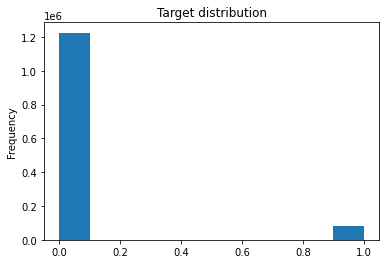

In [ ]:
# To check the TARGET distribution int the dataset
df.target.plot(kind='hist', title='Target distribution');

In [ ]:
#Create tf.data.Datasets for Training and Evaluation:

train_df, remaining = train_test_split(df, random_state=42, train_size=0.0075, stratify=df.target.values)
valid_df, _ = train_test_split(remaining, random_state=42, train_size=0.00075, stratify=remaining.target.values)
train_df.shape, valid_df.shape

((9795, 3), (972, 3))

In [ ]:
# "ataset.from_tensor_slices" used to create dataset from input data and Dataset created using this method will emit only one data at a time, so the full dataset does not need to fit into memory.

with tf.device('/cpu:0'):
  train_data = tf.data.Dataset.from_tensor_slices((train_df.question_text.values, train_df.target.values))
  valid_data = tf.data.Dataset.from_tensor_slices((valid_df.question_text.values, valid_df.target.values))

  for text, label in train_data.take(1):          # the no. of values we want to look that is give by argument "take(1)"
    print(text)
    print(label)

tf.Tensor(b'Why are unhealthy relationships so desirable?', shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)


In [ ]:
#Download a Pre-trained BERT Model from TensorFlow Hub
"""
Each line of the dataset is composed of the review text and its label:-
- Data preprocessing consists of transforming text to BERT input features: input_word_ids, input_mask, segment_ids
- In the process, tokenizing the text is done with the provided BERT model tokenizer

"""
label_list = [0, 1]              # Label categories
max_seq_length = 128     # maximum length of (token) input sequences
train_batch_size = 32


# Get BERT layer and tokenizer:
# More details here: https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2",
                            trainable=True)
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [ ]:
tokenizer.wordpiece_tokenizer.tokenize('hi, how are you doing?');

In [ ]:

tokenizer.convert_tokens_to_ids(tokenizer.wordpiece_tokenizer.tokenize('hi, how are you doing?'))

[7632, 29623, 2129, 2024, 2017, 2725, 29632]

In [ ]:
# Now Tokenize and Preprocess Text for BERT : We'll need to transform our data into a format BERT understands. This involves two steps. First, we create InputExamples using classifier_data_lib's constructor InputExample provided in the BERT library

# This provides a function to convert row to input features and label

def to_feature(text, label, label_list=label_list, max_seq_length=max_seq_length, tokenizer=tokenizer):
  example = classifier_data_lib.InputExample(guid = None,
                                            text_a = text.numpy(), 
                                            text_b = None, 
                                            label = label.numpy())
  feature = classifier_data_lib.convert_single_example(0, example, label_list,
                                    max_seq_length, tokenizer)
  
  return (feature.input_ids, feature.input_mask, feature.segment_ids, feature.label_id)

In [ ]:
#Wrap a Python Function into a TensorFlow op for Eager Execution: So we can't ".map" (because Dataset.map runs in graph mode and they have no values)  this function directly: 
#we need to wrap it in a tf.py_function. The tf.py_function will pass regular tensors (with a value and a .numpy() method to access it), to the wrapped python function.

def to_feature_map(text, label):
  input_ids, input_mask, segment_ids, label_id = tf.py_function(to_feature, inp=[text, label], 
                                Tout=[tf.int32, tf.int32, tf.int32, tf.int32])

  # py_func doesn't set the shape of the returned tensors.
  input_ids.set_shape([max_seq_length])
  input_mask.set_shape([max_seq_length])
  segment_ids.set_shape([max_seq_length])
  label_id.set_shape([])

  x = {
        'input_word_ids': input_ids,
        'input_mask': input_mask,
        'input_type_ids': segment_ids
    }
  return (x, label_id)

# Setting up the input  pipeline

In [ ]:
# Creating a TensorFlow Input Pipeline with tf.data

with tf.device('/cpu:0'):
  # train
  train_data = (train_data.map(to_feature_map,
                              num_parallel_calls=tf.data.experimental.AUTOTUNE)
                          #.cache()
                          .shuffle(1000)
                          .batch(32, drop_remainder=True)
                          .prefetch(tf.data.experimental.AUTOTUNE))

  # valid
  valid_data = (valid_data.map(to_feature_map,
                            num_parallel_calls=tf.data.experimental.AUTOTUNE)
                          .batch(32, drop_remainder=True)
                          .prefetch(tf.data.experimental.AUTOTUNE)) 

In [ ]:
# data spec
train_data.element_spec;
valid_data.element_spec

({'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

# Building the model

In [ ]:
def create_model():
  input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                      name="input_word_ids")
  input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                  name="input_mask")
  input_type_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                  name="input_type_ids")

  pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_type_ids])

  drop = tf.keras.layers.Dropout(0.4)(pooled_output)
  output = tf.keras.layers.Dense(1, activation="sigmoid", name="output")(drop)

  model = tf.keras.Model(
    inputs={
        'input_word_ids': input_word_ids,
        'input_mask': input_mask,
        'input_type_ids': input_type_ids
    },
    outputs=output)
  return model


In [ ]:
 # Fine-Tune BERT for Text Classification:

 model = create_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

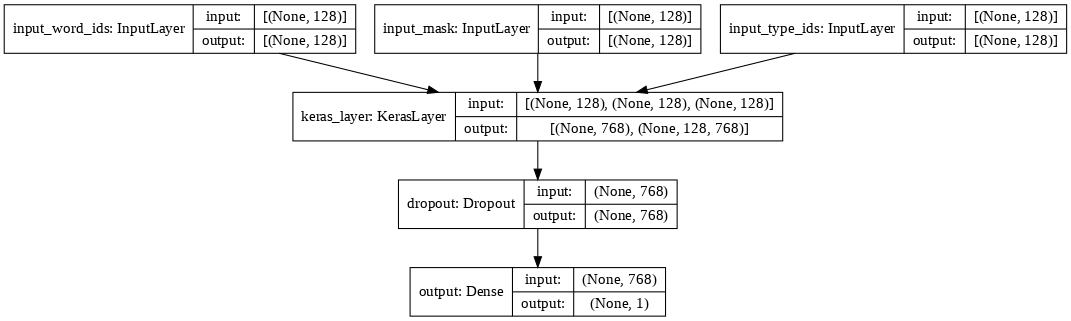

In [ ]:
# Ploting the input and ouput layers that are involved in the model:
tf.keras.utils.plot_model(model=model, show_shapes=True, dpi=76, )

In [ ]:
# Train model: it takes around 15-20 minutes (depends on internet speed) to train the model!!!!

epochs = 4
history = model.fit(train_data,
                    validation_data=valid_data,
                    epochs=epochs,
                    verbose=1)

In [ ]:
#Evaluate the BERT Text Classification Model:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

In [ ]:
plot_graphs(history, 'binary_accuracy');
plot_graphs(history, 'loss')

In [ ]:
model.evaluate(valid_data, verbose=1)

# Testing the model on random examples:

In [ ]:
sample_example = ["Which is the best college/university to do an MBA in Ind",\
                  "Are Indian universities providing enough industry exposure to their students?",\
                  "What is the power of a single person?",\
                  "What disturbs or saddens you?",\
                  "Is it okay for me to think I'm useless and my life has no worth? I really don't know what I'm doing, I have no will to do anything nor even ability to change it.",\
                  "What Bollywood actress has the best and hottest navel?"]
                  
test_data = tf.data.Dataset.from_tensor_slices((sample_example, [0]*len(sample_example)))
test_data = (test_data.map(to_feature_map).batch(1))
preds = model.predict(test_data)
#['Toxic' if pred >=0.5 else 'Sincere' for pred in preds]

In [ ]:
preds.

In [ ]:
test_data